Here we perform different transforms in order to prepare our data for models.

Transforms:
- DFT
- Wavelet

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pywt
import csv
import glob
import os
import glob
import tqdm
import datetime

# load data
X = np.load("data/data_X.npy")
y = np.load("data/data_y.npy")

N_samples = X.shape[0]
print(N_samples)

sample_idx = np.random.randint(0, N_samples, 10)

6372


In [8]:
print(np.unique(y, return_counts=True))

(array([ 0.,  1.,  2.,  3.,  4.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22.]), array([319, 340, 278, 275, 273, 341, 343, 358, 174, 347, 363, 267, 240,
       349,  48, 335, 323, 208, 272, 323, 236, 360]))


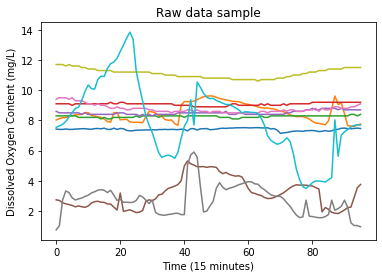

In [9]:
for idx in sample_idx:
    plt.plot(X[idx, :])
plt.title("Raw data sample")
plt.ylabel("Dissolved Oxygen Content (mg/L)")
plt.xlabel("Time (15 minutes)")
plt.show()

### DFT transform

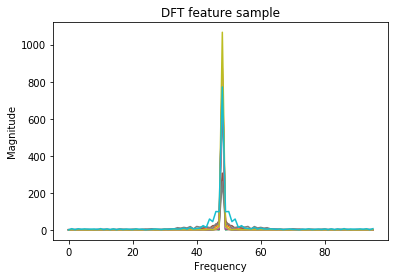

In [20]:
X_dft = np.zeros(X.shape)
for i in range(N_samples):
    X_dft[i,:] = np.abs(np.fft.fftshift(np.fft.fft(X[i,:])))

for idx in sample_idx:
    plt.plot(X_dft[idx, :])
plt.title("DFT feature sample")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

### Scalograms using CWT

[5.27238573 5.23401052 5.15027462 5.02120753 4.94928826 4.9909138
 4.83967751 4.85997427 4.82375861 4.72075138 4.7421856  4.73388297
 5.59854981 5.56252522 5.37493165 5.06214834 4.16233784 3.71581452
 3.67980026 3.95336079 4.27840034 4.49409821 4.669176   4.73624976
 4.72639588 4.75022722 5.00709729 5.00709729 4.70801962 4.59234924
 4.51722921 4.38958208 4.14508125 3.83897956 3.78493593 3.73217076
 3.62135454 3.79169088 4.47530318 5.46189627 5.65109581 5.70141714
 5.72169631 5.77406695 5.80386957 5.86190032 5.96041486 6.05687214
 6.19079843 6.02499233 5.89763093 5.63439286 5.67453691 5.58901009
 5.50650311 5.42668619 5.37203558 5.46263133 5.48555776 5.34970005
 4.91065559 4.52584464 4.56098267 4.53144879 4.71907903 5.1158914
 5.32346596 5.48200519 5.55286783 5.50879414 5.49786931 5.36182188
 5.35474879 5.40465639 5.40376405 5.4181744  5.34353999 5.3208704
 5.30324622 5.14777311 4.86460461 4.68478594 4.52648885 4.38422693
 4.36226793 4.58585891 4.70823347 4.75946686 4.82990199 4.9575824

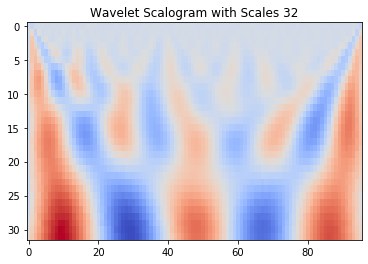

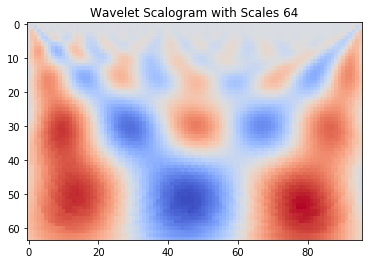

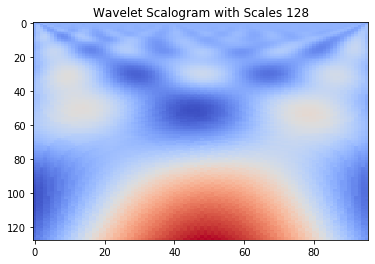

In [59]:
rand_idx = np.random.randint(0, X.shape[0])
sample_X = X[rand_idx, :]
print(sample_X)
for scale in [32, 64, 128]:
    scales = np.arange(1, scale + 1)
    coeffs, freqs = pywt.cwt(sample_X, scales, wavelet = "morl")
    plt.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
    plt.title("Wavelet Scalogram with Scales " + str(scale))
    plt.show()

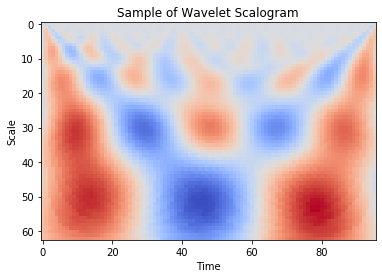

In [60]:
# generate final plot for report
scales = np.arange(1, 64)
report_X = X[rand_idx, :]
coeffs, freqs = pywt.cwt(sample_X, scales, wavelet = "morl")
plt.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
plt.title("Sample of Wavelet Scalogram")
plt.xlabel("Time")
plt.ylabel("Scale")
plt.show()

### DWT transform

In [94]:
from collections import defaultdict, Counter
import scipy
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy = scipy.stats.entropy(probabilities)
    return entropy
 
def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]
 
def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]
 
def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

In [105]:
def create_dwt_mat(X, mother_signal):
    num_features = 12
    num_samples = X.shape[0]
    sample_coeff = pywt.wavedec(X[0,:], mother_signal)
    feature_out = np.zeros((num_samples, len(sample_coeff)*num_features))
    for i in range(num_samples):
        this_signal = X[i,:]
        coeffs = pywt.wavedec(this_signal, mother_signal)
        for j in range(len(coeffs)):
            these_features = np.array(get_features(coeffs[j]))
            feature_out[i, j*num_features:j*num_features + num_features] = these_features
    return feature_out        

In [108]:
X_dwt = create_dwt_mat(X, "db5")

In [21]:
np.save("data/X_dft.npy", X_dft)
# np.save("X_dwt.npy", X_dwt)